In [1]:
import sqlalchemy
from sqlalchemy import (create_engine, Column, String, Integer, Float, MetaData, 
                        Table, type_coerce, ForeignKey, case)
from sqlalchemy.orm import mapper, create_session, relationship, aliased, Session
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import case
import numpy as np
from sqlalchemy.ext.automap import automap_base
import matplotlib.pyplot as plt
import sqlalchemy.types as types
from sqlalchemy.sql import and_, or_, not_, func
from sqlalchemy.sql import select
import os
from os.path import isfile
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import datetime
import glob
import gsw
import pickle
import matplotlib as mpl

import scipy.optimize as scopt

%matplotlib inline

In [2]:
basedir='/ocean/shared/SalishSeaCastData/DFO/CTD/'
dbname='DFO_CTD.sqlite'
datelims=()
engine = create_engine('sqlite:///' + basedir + dbname, echo = False)
Base = automap_base()
# reflect the tables in salish.sqlite:
Base.prepare(engine, reflect=True)
# mapped classes have been created
# existing tables:
StationTBL=Base.classes.StationTBL
ObsTBL=Base.classes.ObsTBL
CalcsTBL=Base.classes.CalcsTBL
session = create_session(bind = engine, autocommit = False, autoflush = True)


In [3]:
session.query(ObsTBL.PAR1_units).distinct().all()

[(None), ('uE/m^2/sec')]

In [4]:
session.query(ObsTBL.PAR_1_units).distinct().all()

[(None), ('uE/m^2/sec')]

In [5]:
PAR=case([(ObsTBL.PAR!=None, ObsTBL.PAR)], else_=
             case([(ObsTBL.PAR1!=None, ObsTBL.PAR1)], else_=ObsTBL.PAR_1))

In [6]:
SA=case([(CalcsTBL.Salinity_T0_C0_SA!=None, CalcsTBL.Salinity_T0_C0_SA)], else_=
         case([(CalcsTBL.Salinity_T1_C1_SA!=None, CalcsTBL.Salinity_T1_C1_SA)], else_=
         case([(CalcsTBL.Salinity_SA!=None, CalcsTBL.Salinity_SA)], else_= None)))
CT=case([(CalcsTBL.Temperature_Primary_CT!=None, CalcsTBL.Temperature_Primary_CT)], else_=
         case([(CalcsTBL.Temperature_Secondary_CT!=None, CalcsTBL.Temperature_Secondary_CT)], else_=CalcsTBL.Temperature_CT))
ZD=case([(ObsTBL.Depth!=None,ObsTBL.Depth)], else_= CalcsTBL.Z)

In [7]:
qry=session.query(StationTBL.ID,StationTBL.sourceFile.label('staFile'),ObsTBL.sourceFile.label('obsFile'),StationTBL.StartYear.label('Year'),StationTBL.StartMonth.label('Month'),
                StationTBL.StartDay.label('Day'),StationTBL.StartHour.label('Hour'),
                StationTBL.Lat,StationTBL.Lon,ZD.label('Z'),PAR.label('PAR'),SA.label('SA'),CT.label('CT')).\
        select_from(StationTBL).join(ObsTBL,ObsTBL.StationTBLID==StationTBL.ID).\
        join(CalcsTBL,CalcsTBL.ObsTBLID==ObsTBL.ID).filter(and_(StationTBL.Lat>47-3/2.5*(StationTBL.Lon+123.5),
                                            StationTBL.Lat<47-3/2.5*(StationTBL.Lon+121),
                                            StationTBL.Lat<51,
                                            StationTBL.Include==True,ObsTBL.Include==True,
                                            ObsTBL.PAR>=0))


In [ ]:
qry2=session.query(StationTBL.StartYear.label('Year'),StationTBL.StartMonth.label('Month'),
                StationTBL.StartDay.label('Day'),StationTBL.StartHour.label('Hour'),
                StationTBL.Lat,StationTBL.Lon,func.min(ZD).label('minZ')).\
        select_from(StationTBL).join(ObsTBL,ObsTBL.StationTBLID==StationTBL.ID).\
        join(CalcsTBL,CalcsTBL.ObsTBLID==ObsTBL.ID).filter(and_(StationTBL.Lat>47-3/2.5*(StationTBL.Lon+123.5),
                                            StationTBL.Lat<47-3/2.5*(StationTBL.Lon+121),
                                            StationTBL.Lat<51,
                                            StationTBL.Include==True,ObsTBL.Include==True,
                                            ObsTBL.PAR>=0)).group_by(StationTBL.ID)
minzQ=session.query(StationTBL.ID,func.min(ZD).label('minZ')).\
        select_from(StationTBL).join(ObsTBL,ObsTBL.StationTBLID==StationTBL.ID).\
        join(CalcsTBL,CalcsTBL.ObsTBLID==ObsTBL.ID).filter(and_(StationTBL.Lat>47-3/2.5*(StationTBL.Lon+123.5),
                                            StationTBL.Lat<47-3/2.5*(StationTBL.Lon+121),
                                            StationTBL.Lat<51,
                                            StationTBL.Include==True,ObsTBL.Include==True,
                                            ObsTBL.PAR>=0)).group_by(StationTBL.ID)

In [ ]:
df2=pd.DataFrame(qry2.all())


In [ ]:
df3=pd.DataFrame(minzQ.all())

In [8]:
df1=pd.DataFrame(qry.all())

In [ ]:
len(df2),len(df1),len(df3)

In [ ]:
subminzQ=minzQ.subquery()
subqry=qry.subquery()

In [ ]:
sparQ=session.query(subminzQ.c.ID,subminzQ.c.minZ,subqry.c.PAR).select_from(subminzQ).join(subqry,and_(
    ObsTBL.)

In [9]:
df1=pd.DataFrame(qry.all())
df1['dtUTC']=[dt.datetime(int(y),int(m),int(d))+dt.timedelta(hours=h) for y,m,d,h in zip(df1['Year'],df1['Month'],df1['Day'],df1['Hour'])]


In [10]:
len(df1)

319619

In [11]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as mesh:
    tmask=np.copy(mesh.variables['tmask'][0,:,:,:])
    navlat=np.copy(mesh.variables['nav_lat'][:,:])
    navlon=np.copy(mesh.variables['nav_lon'][:,:])

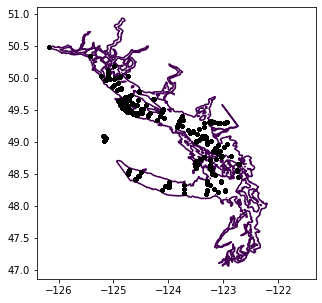

In [12]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.plot(df1['Lon'],df1['Lat'],'k.')
ax.contour(navlon,navlat,tmask[0,:,:],(0.5,))

In [13]:
df1.head()

,ID,staFile,obsFile,Year,Month,Day,Hour,Lat,Lon,Z,PAR,SA,CT,dtUTC
0,1,"req20181116/EO UBC November 16, 2018 (2014 dat...","req20181116/EO UBC November 16, 2018 (2014 dat...",2014.0,2.0,11.0,6.598056,48.618333,-123.248333,0.991551,0.3,31.189609,7.327741,2014-02-11 06:35:53
1,1,"req20181116/EO UBC November 16, 2018 (2014 dat...","req20181116/EO UBC November 16, 2018 (2014 dat...",2014.0,2.0,11.0,6.598056,48.618333,-123.248333,1.983098,0.2,31.191168,7.327932,2014-02-11 06:35:53
2,1,"req20181116/EO UBC November 16, 2018 (2014 dat...","req20181116/EO UBC November 16, 2018 (2014 dat...",2014.0,2.0,11.0,6.598056,48.618333,-123.248333,2.974640,0.2,31.191120,7.327442,2014-02-11 06:35:53
3,1,"req20181116/EO UBC November 16, 2018 (2014 dat...","req20181116/EO UBC November 16, 2018 (2014 dat...",2014.0,2.0,11.0,6.598056,48.618333,-123.248333,3.966176,0.1,31.197000,7.329882,2014-02-11 06:35:53
4,1,"req20181116/EO UBC November 16, 2018 (2014 dat...","req20181116/EO UBC November 16, 2018 (2014 dat...",2014.0,2.0,11.0,6.598056,48.618333,-123.248333,4.957709,0.1,31.201373,7.331038,2014-02-11 06:35:53


In [14]:
df1.tail()

,ID,staFile,obsFile,Year,Month,Day,Hour,Lat,Lon,Z,PAR,SA,CT,dtUTC
319614,5692,"req20181116/EO UBC November 16, 2018 (2018 dat...","req20181116/EO UBC November 16, 2018 (2018 dat...",2018.0,2.0,7.0,1.859167,49.304833,-122.941167,25.8,0.0,26.732853,8.801723,2018-02-07 01:51:33
319615,5692,"req20181116/EO UBC November 16, 2018 (2018 dat...","req20181116/EO UBC November 16, 2018 (2018 dat...",2018.0,2.0,7.0,1.859167,49.304833,-122.941167,26.8,0.0,26.812974,8.875391,2018-02-07 01:51:33
319616,5692,"req20181116/EO UBC November 16, 2018 (2018 dat...","req20181116/EO UBC November 16, 2018 (2018 dat...",2018.0,2.0,7.0,1.859167,49.304833,-122.941167,27.8,0.0,26.978804,9.042280,2018-02-07 01:51:33
319617,5692,"req20181116/EO UBC November 16, 2018 (2018 dat...","req20181116/EO UBC November 16, 2018 (2018 dat...",2018.0,2.0,7.0,1.859167,49.304833,-122.941167,28.8,0.0,27.031492,9.102279,2018-02-07 01:51:33
319618,5692,"req20181116/EO UBC November 16, 2018 (2018 dat...","req20181116/EO UBC November 16, 2018 (2018 dat...",2018.0,2.0,7.0,1.859167,49.304833,-122.941167,29.8,0.0,27.042581,9.120496,2018-02-07 01:51:33


In [15]:
flen=1
namfmt='nowcast'
#varmap={'N':'nitrate','Si':'silicon','Ammonium':'ammonium'}
filemap={'PAR':'carp_T','vosaline':'grid_T','votemper':'grid_T'}
#gridmap={'nitrate':'tmask','silicon':'tmask','ammonium':'tmask'}
fdict={'carp_T':1,'grid_T':1}
PATH='/results/SalishSea/nowcast-green.201812/'
data=et.matchData(df1,filemap,fdict,dt.datetime(2015,1,1),dt.datetime(2018,1,1),namfmt,PATH,flen)

(Lat,Lon)= 49.01133333333333 -125.17  not matched to domain
(Lat,Lon)= 49.021 -125.15616666666666  not matched to domain
(Lat,Lon)= 49.0295 -125.15266666666666  not matched to domain
(Lat,Lon)= 49.042833333333334 -125.15266666666666  not matched to domain
(Lat,Lon)= 49.0525 -125.143  not matched to domain
(Lat,Lon)= 49.071333333333335 -125.15683333333334  not matched to domain
(Lat,Lon)= 49.08316666666666 -125.17166666666667  not matched to domain
(Lat,Lon)= 49.09166666666667 -125.19466666666666  not matched to domain
(Lat,Lon)= 49.29533333333333 -122.9685  not matched to domain
(Lat,Lon)= 49.29966666666667 -123.09016666666666  not matched to domain
(Lat,Lon)= 49.315666666666665 -122.9375  not matched to domain
(Lat,Lon)= 50.02883333333333 -124.7325  not matched to domain
progress: 0.0%
progress: 2.462350658432566%
progress: 4.924701316865132%
progress: 7.387051975297698%
progress: 9.849402633730264%
progress: 12.31175329216283%
progress: 14.774103950595396%
progress: 17.23645460902796

In [16]:
pickle.dump(data,open('loadPARCTD2.pkl','wb'))

In [3]:
data=pickle.load(open('loadPARCTD.pkl','rb'))

In [28]:
data.drop(data[data.k<0].index,inplace=True)

In [29]:
data

,Year,Month,Day,Hour,Lat,Lon,Z,PAR,SA,CT,dtUTC,j,i,mod_PAR,mod_vosaline,mod_votemper,k,mod_Z
0,2015.0,2.0,11.0,5.296111,48.613333,-123.243833,1.983099,0.2,29.849611,8.942753,2015-02-11 05:17:46,328,240,0.0,29.437077,9.076343,1,1.500003
1,2015.0,2.0,11.0,5.296111,48.613333,-123.243833,2.974641,0.1,29.852177,8.942511,2015-02-11 05:17:46,328,240,0.0,29.539558,9.086275,2,2.500011
2,2015.0,2.0,11.0,5.296111,48.613333,-123.243833,3.966178,0.1,29.869012,8.941135,2015-02-11 05:17:46,328,240,0.0,29.665234,9.094213,3,3.500031
3,2015.0,2.0,11.0,5.296111,48.613333,-123.243833,4.957711,0.0,29.915690,8.936661,2015-02-11 05:17:46,328,240,0.0,29.739351,9.096522,4,4.500071
4,2015.0,2.0,11.0,5.296111,48.613333,-123.243833,5.949239,0.0,29.913935,8.936489,2015-02-11 05:17:46,328,240,0.0,29.781431,9.099732,5,5.500151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203053,2017.0,10.0,9.0,8.238889,49.238333,-123.845667,244.800000,0.0,31.318198,9.686366,2017-10-09 08:14:20,492,230,0.0,31.414436,9.368121,32,253.066635
203054,2017.0,10.0,9.0,8.238889,49.238333,-123.845667,245.800000,0.0,31.318619,9.687753,2017-10-09 08:14:20,492,230,0.0,31.414436,9.368121,32,253.066635
203055,2017.0,10.0,9.0,8.238889,49.238333,-123.845667,246.700000,0.0,31.318937,9.688650,2017-10-09 08:14:20,492,230,0.0,31.414436,9.368121,32,253.066635
203056,2017.0,10.0,9.0,8.238889,49.238333,-123.845667,247.900000,0.0,31.318758,9.687919,2017-10-09 08:14:20,492,230,0.0,31.414436,9.368121,32,253.066635


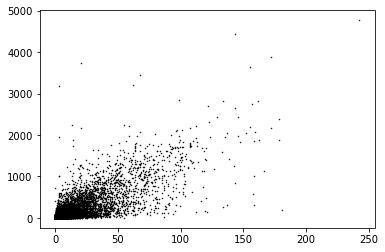

In [30]:
plt.plot(data['mod_PAR'],data['PAR'],'k.',ms=1)

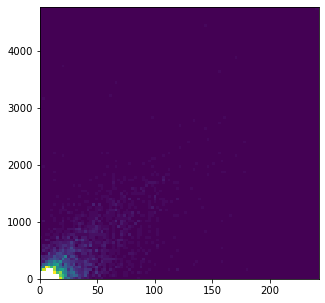

In [32]:
ii=(data['mod_PAR']>=0)&(data['PAR']>=0)
fig,ax=plt.subplots(1,1,figsize=(5,5))
xx=data.loc[ii,['mod_PAR']].values
yy=data.loc[ii,['PAR']].values
ax.hist2d(xx[:,0],yy[:,0],bins=100,cmin=0,cmax=50);

Text(0.5, 1.0, 'PAR Direct Comparison: HC201812')

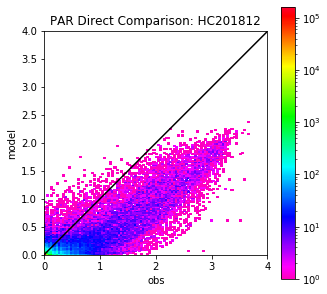

In [33]:
ii=(data['mod_PAR']>=0)&(data['PAR']>=0)
fig,ax=plt.subplots(1,1,figsize=(5,5))
yy=data.loc[ii,['mod_PAR']].values
xx=data.loc[ii,['PAR']].values
_,_,_,m=ax.hist2d(np.log10(xx[:,0]+1),np.log10(yy[:,0]+1),bins=100,norm=mpl.colors.LogNorm(), cmap=mpl.cm.gist_rainbow_r);
fig.colorbar(m,ax=ax)
ax.set_xlim(0,4)
ax.set_ylim(0,4)
ax.set_aspect(1)
ax.plot((0,4),(0,4),'k-')
ax.set_xlabel('obs')
ax.set_ylabel('model')
ax.set_title('PAR Direct Comparison: HC201812')

In [34]:
data.keys()

Index(['Year', 'Month', 'Day', 'Hour', 'Lat', 'Lon', 'Z', 'PAR', 'SA', 'CT',
       'dtUTC', 'j', 'i', 'mod_PAR', 'mod_vosaline', 'mod_votemper', 'k',
       'mod_Z'],
      dtype='object')

In [35]:
stas=data.groupby(by=['Year','Month','Day','Lat','Lon'])

In [36]:
stas

In [19]:
with nc.Dataset('/results/SalishSea/nowcast-green.201812/01jan16/SalishSea_1h_20160101_20160101_ptrc_T.nc') as ftemp:
    deptht=ftemp.variables['deptht'][:]

In [38]:
deptht[5]

5.5001507

In [20]:
data['mod_Z']=[deptht[ii] for ii in data['k']]

Text(0, 0.5, 'Model')

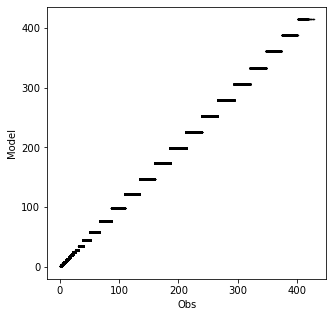

In [40]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.plot(data['Z'],data['mod_Z'],'k.',ms=1)
ax.set_xlabel('Obs')
ax.set_ylabel('Model')

Text(0.5, 1.0, 'PAR Direct Comparison Upper 10m: HC201812')

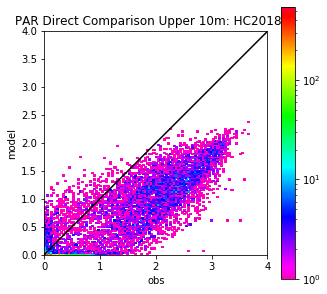

In [44]:
ii=(data['mod_PAR']>=0)&(data['PAR']>=0)
ik=data.k<10
fig,ax=plt.subplots(1,1,figsize=(5,5))
yy=data.loc[ii&ik,['mod_PAR']].values
xx=data.loc[ii&ik,['PAR']].values
yz=data.loc[ii&ik,['mod_Z']].values
xz=data.loc[ii&ik,['Z']].values
_,_,_,m=ax.hist2d(np.log10(xx[:,0]+1),np.log10(yy[:,0]+1),bins=100,norm=mpl.colors.LogNorm(), cmap=mpl.cm.gist_rainbow_r);
fig.colorbar(m,ax=ax)
ax.set_xlim(0,4)
ax.set_ylim(0,4)
ax.set_aspect(1)
ax.plot((0,4),(0,4),'k-')
ax.set_xlabel('obs')
ax.set_ylabel('model')
ax.set_title('PAR Direct Comparison Upper 10m: HC201812')

Text(0.5, 1.0, 'hist: model z - obs z')

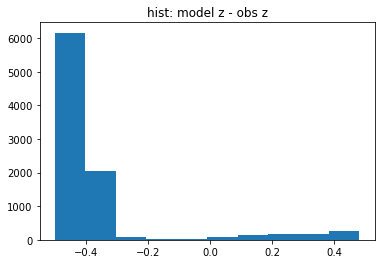

In [51]:
plt.hist(yz-xz)
plt.title('hist: model z - obs z')

Text(0, 0.5, 'log10(model PAR +1)-log10(obs PAR +1)')

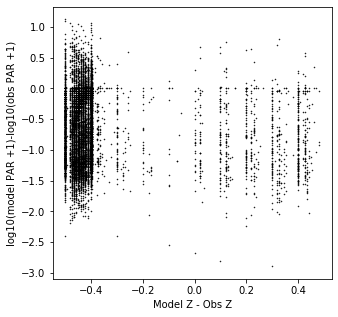

In [49]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.plot(yz-xz,np.log10(yy[:,0]+1)-np.log10(xx[:,0]+1),'k.',ms=1)
ax.set_xlabel('Model Z - Obs Z')
ax.set_ylabel('log10(model PAR +1)-log10(obs PAR +1)')

Text(0.5, 1.0, 'PAR Direct Comparison Upper 2m: HC201812')

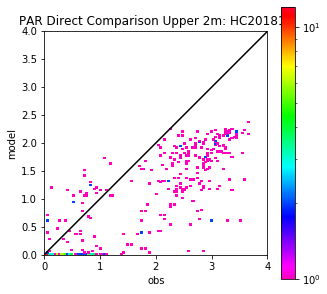

In [53]:
ii=(data['mod_PAR']>=0)&(data['PAR']>=0)
ik=data.k<2
fig,ax=plt.subplots(1,1,figsize=(5,5))
yy=data.loc[ii&ik,['mod_PAR']].values
xx=data.loc[ii&ik,['PAR']].values
yz=data.loc[ii&ik,['mod_Z']].values
xz=data.loc[ii&ik,['Z']].values
_,_,_,m=ax.hist2d(np.log10(xx[:,0]+1),np.log10(yy[:,0]+1),bins=100,norm=mpl.colors.LogNorm(), cmap=mpl.cm.gist_rainbow_r);
fig.colorbar(m,ax=ax)
ax.set_xlim(0,4)
ax.set_ylim(0,4)
ax.set_aspect(1)
ax.plot((0,4),(0,4),'k-')
ax.set_xlabel('obs')
ax.set_ylabel('model')
ax.set_title('PAR Direct Comparison Upper 2m: HC201812')

In [17]:
data.keys()

Index(['ID', 'staFile', 'obsFile', 'Year', 'Month', 'Day', 'Hour', 'Lat',
       'Lon', 'Z', 'PAR', 'SA', 'CT', 'dtUTC', 'j', 'i', 'mod_PAR',
       'mod_vosaline', 'mod_votemper', 'k'],
      dtype='object')

In [48]:
temp=data.loc[(data['PAR']>10)&(data['mod_PAR']==0)&(data['Z']<3),['dtUTC','Lat','Lon','Z','mod_Z','Hour','staFile','obsFile']]

In [49]:
temp

,dtUTC,Lat,Lon,Z,mod_Z,Hour,staFile,obsFile
141507,2017-04-10 05:28:59,48.183500,-123.318000,1.0,0.500000,5.483056,"req20181116/EO UBC November 16, 2018 (2017 dat...","req20181116/EO UBC November 16, 2018 (2017 dat..."
202807,2017-10-09 08:14:20,49.238333,-123.845667,1.3,1.500003,8.238889,"req20181116/EO UBC November 16, 2018 (2017 dat...","req20181116/EO UBC November 16, 2018 (2017 dat..."


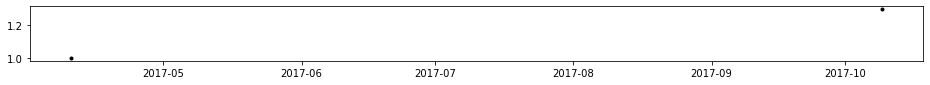

In [50]:
fig,ax=plt.subplots(1,1,figsize=(16,1))
ax.plot(temp['dtUTC'],temp['Z'],'k.')

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([5.48305556, 5.75863889, 6.03422222, 6.30980556, 6.58538889,
        6.86097222, 7.13655556, 7.41213889, 7.68772222, 7.96330556,
        8.23888889]),
 <a list of 10 Patch objects>)

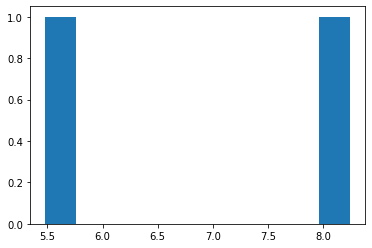

In [51]:
plt.hist(temp['Hour'])

In [52]:
len(temp)

2

In [53]:
np.unique(temp['staFile'])

array(['req20181116/EO UBC November 16, 2018 (2017 data)/2017-63-0017.ctd',
       'req20181116/EO UBC November 16, 2018 (2017 data)/2017-65-0125.ctd'],
      dtype=object)

In [54]:
np.unique(temp['obsFile'])

array(['req20181116/EO UBC November 16, 2018 (2017 data)/2017-63-0017.ctd',
       'req20181116/EO UBC November 16, 2018 (2017 data)/2017-65-0125.ctd'],
      dtype=object)

(0, 10000)

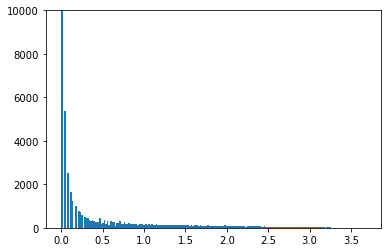

In [55]:
plt.hist(np.log10(data['PAR']+1),200);
plt.ylim(0,10000)

In [38]:
10**.5-1

2.1622776601683795

In [56]:
data.loc[data['obsFile']=='req20181116/EO UBC November 16, 2018 (2017 data)/2017-63-0017.ctd',['dtUTC','PAR']]

,dtUTC,PAR
141507,2017-04-10 05:28:59,11.3
141508,2017-04-10 05:28:59,6.6
141509,2017-04-10 05:28:59,1.7
141510,2017-04-10 05:28:59,1.3
141511,2017-04-10 05:28:59,0.9
...,...,...
141587,2017-04-10 05:28:59,0.0
141588,2017-04-10 05:28:59,0.0
141589,2017-04-10 05:28:59,0.0
141590,2017-04-10 05:28:59,0.0


nighttime; probably moonlight